## LSTM Auto-Encoder-Decoder for Anomaly Detection: 
Based on Philip Jeremy's work from (https://gist.github.com/philipperemy/b8a7b7be344e447e7ee6625fe2fdd765)

## Detect anomalous points on time series data of cpu utilization

In [240]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
np.random.seed(23)

### Read Data for Cpu utilization, we want to reconstruct the time series using LSTM based Auto-Encoder

In [242]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [243]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


**We collect cpu usage data per hour eveyday, so there are 24 readings per day**

In [244]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [245]:
# normalize the dataset
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

In [246]:
df['cpu_util_pctg'] = df['cpu_util_pctg'] / 100

In [247]:
#from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
#scaler = StandardScaler()
#df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

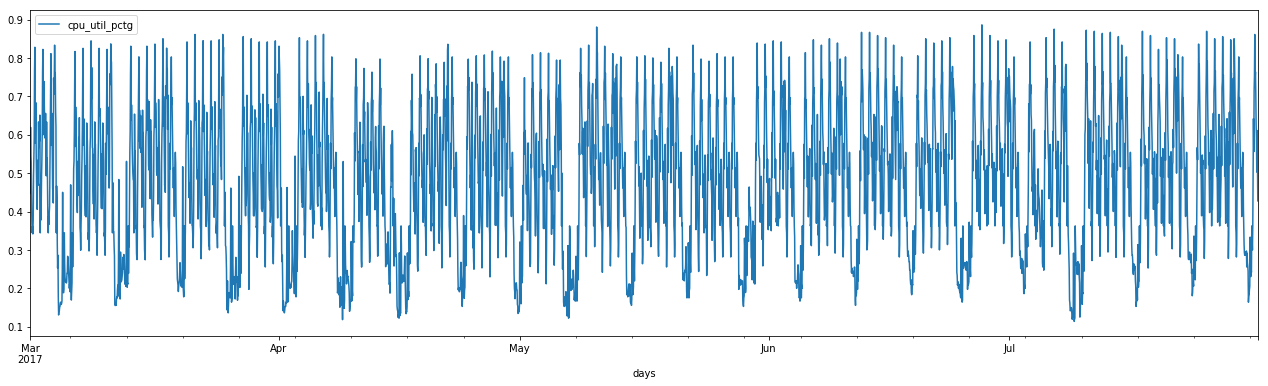

In [248]:
df.plot(figsize=(22,6));

In [249]:
len(df)

3672

### Create the training, validation and test sets

In [250]:
signal_train = df['2017-03-01':'2017-05-31'].values # March to May
signal_valid = df['2017-06-01':'2017-06-30'].values # June
signal_test = df['2017-07-01':'2017-07-31'].values # July

**Prepare Training Sequences: Create windows of 48 data points each**

In [251]:
window_length = 48 # Why 48? 24 readings in a day, so took for 2 days

In [252]:
train_windows = []

In [253]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [254]:
len(train_windows)

2161

In [255]:
len(signal_test)

744

In [256]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [257]:
x_train = np.array(train_windows)
x_train.shape

(2161, 48, 1)

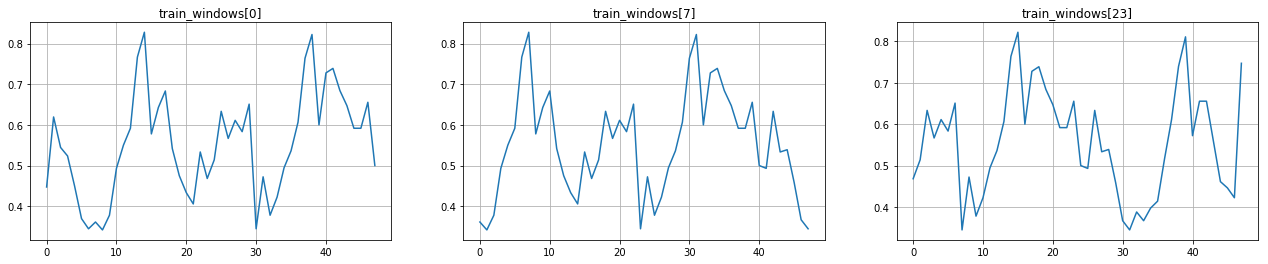

In [258]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [259]:
valid_windows = []

In [260]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [261]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [262]:
x_valid = np.array(valid_windows)
x_valid.shape

(673, 48, 1)

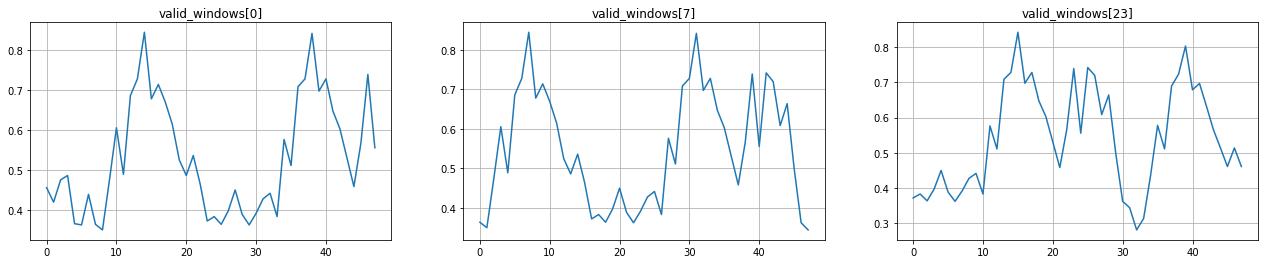

In [263]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [264]:
hidden_dim = 24
batch_size = 168 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50

In [265]:
# Based on Philip Jeremy's implementation
#select_only_last_state = False
#def model1():
#    m = Sequential()
#    if select_only_last_state:
#        m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
#        m.add(RepeatVector(window_length))
#    else:
#        m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
#    m.add(Dropout(rate=0.1))
#    m.add(LSTM(1, return_sequences=True, activation='linear'))
#    m.compile(loss='mse', optimizer='adam')
#    return m

In [266]:
# Based on Pankaj's suggestion
from seq2seq import Seq2Seq
input_length = window_length
input_dim = 1

output_length = window_length
output_dim = 1

hidden_dim = 24

def model2():
    m = Seq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim), depth=2, dropout=0.1)
    m.compile(loss='mse', optimizer='sgd')
    return m

In [267]:
#m = model1()
m = model2()

In [ ]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_388 (InputLayer)           (None, 48, 1)         0                                            
____________________________________________________________________________________________________
time_distributed_10 (TimeDistrib (None, 48, 24)        48          input_388[0][0]                  
____________________________________________________________________________________________________
private__optional_input_place_ho (2,)                  0                                            
____________________________________________________________________________________________________
private__optional_input_place_ho (2,)                  0                                            
___________________________________________________________________________________________

In [ ]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), shuffle=False).history

Train on 2161 samples, validate on 673 samples
Epoch 1/50
2161/2161 [==============================] - 14s - loss: 0.2010 - val_loss: 0.1744
Epoch 2/50
2161/2161 [==============================] - 6s - loss: 0.1284 - val_loss: 0.1175
Epoch 3/50
2161/2161 [==============================] - 6s - loss: 0.0889 - val_loss: 0.0852
Epoch 4/50
2161/2161 [==============================] - 6s - loss: 0.0669 - val_loss: 0.0663
Epoch 5/50
2161/2161 [==============================] - 6s - loss: 0.0543 - val_loss: 0.0548
Epoch 6/50
2161/2161 [==============================] - 6s - loss: 0.0469 - val_loss: 0.0476
Epoch 7/50
2161/2161 [==============================] - 6s - loss: 0.0424 - val_loss: 0.0429
Epoch 8/50
2161/2161 [==============================] - 6s - loss: 0.0396 - val_loss: 0.0397
Epoch 9/50
2161/2161 [==============================] - 6s - loss: 0.0379 - val_loss: 0.0376
Epoch 10/50
2161/2161 [==============================] - 6s - loss: 0.0367 - val_loss: 0.0360
Epoch 11/50
2161/2161

In [ ]:
#model_file = 'auto-encoder-anom.h5'
#m.save(model_file)

In [ ]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

In [ ]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

In [ ]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

In [ ]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [ ]:
signal_test[201]

In [ ]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

### Simulate Anomalies on the test set (select random points)

In [ ]:
simulated_signal_test = np.copy(signal_test)

In [ ]:
random_indices = [201, 422] # random points chosen
simulated_signal_test[201] = 80
simulated_signal_test[422] = 35

In [ ]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [ ]:
test_windows = []
contain_outliers= []

In [ ]:
for window_start in range(0, len(simulated_signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(simulated_signal_test[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [ ]:
x_test = np.array(test_windows)
x_test.shape

In [ ]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

In [ ]:
outlier_indices = np.where(contain_outliers)[0]

In [ ]:
outlier_indices

In [ ]:
# Visualize the reconstruction on test sequence[201]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[158])
plt.title('x_test[158]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[158], color='darkorange')
plt.title('pred_x_test[158]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[158], label='test')
plt.plot(pred_x_test[158], label='pred')
plt.plot(201 - 158, x_test[158][201-158], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[158]')
plt.grid(True)
plt.show();

In [ ]:
# Visualize the reconstruction on test sequence[422]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[415])
plt.title('x_test[415]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[415], color='darkorange')
plt.title('pred_x_test[415]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[415], label='test')
plt.plot(pred_x_test[415], label='pred')
plt.plot(422 - 415, x_test[415][422-415], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[415]')
plt.grid(True)
plt.show();

In [ ]:
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_of_predictions

In [ ]:
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
mae_threshold

In [ ]:
pred_outlier_indices = np.where(mae_of_predictions > mae_threshold)[0]
pred_outlier_indices

In [ ]:
len(pred_outlier_indices)

In [ ]:
len(outlier_indices)